# Tarea 3 - Detección de Sarcasmo en Texto

### Nombre: Benjamín Farías V.

# Preparación de Datos

A continuación se leen los datos desde el archivo `.json`:

In [107]:
import json
from spacy.lang.en.stop_words import STOP_WORDS

# Se carga la base de datos de manera local, eliminando las Stop Words de forma manual
def parse_data(path):
    items = []
    with open(path, encoding='utf-8') as file:
        for line in file:
            clean_line = ' '.join([word for word in line.split() if word.lower() not in STOP_WORDS])
            item = json.loads(clean_line)
            items.append(item)
    return items

data = parse_data('Sarcasm_Headlines_Dataset_v2.json') # Usamos la v2 del dataset

Ahora extraemos los textos y su atributo que indica si son sarcásticos o no:

In [108]:
x_in = [x['headline'].replace("'","").replace(":","") for x in data]
y = [x['is_sarcastic'] for x in data]

El siguiente código imprime una muestra de los 10 primeros elementos no sarcásticos y sarcásticos encontrados en el dataset:

In [109]:
print('Muestra de algunos elementos del dataset:')
sample = ['-(NOT SARCASTIC) ' + x_in[i] for i in range(len(x_in)) if not y[i]][:10]
sample = sample + ['-(SARCASTIC)     ' + x_in[i] for i in range(len(x_in)) if y[i]][:10]
print('\n'+'\n'.join(sample))

Muestra de algunos elementos del dataset:

-(NOT SARCASTIC) dem rep. totally nails congress falling short gender, racial equality
-(NOT SARCASTIC) eat veggies 9 deliciously different recipes
-(NOT SARCASTIC) my white inheritance
-(NOT SARCASTIC) 5 ways file taxes stress
-(NOT SARCASTIC) lots parents know scenario
-(NOT SARCASTIC) this lesbian considered father indiana (and amazing that)
-(NOT SARCASTIC) amanda peet told daughter sex a special hug
-(NOT SARCASTIC) what know current treatments ebola
-(NOT SARCASTIC) chris christie suggests hillary clinton blame boko harams kidnapping hundreds schoolgirls
-(NOT SARCASTIC) uber ceo travis kalanick stepping trump economic advisory council
-(SARCASTIC)     thirtysomething scientists unveil doomsday clock hair loss
-(SARCASTIC)     inclement weather prevents liar getting work
-(SARCASTIC)     mother comes pretty close word streaming correctly
-(SARCASTIC)     richard bransons global-warming donation nearly cost failed balloon trips
-(SARCASTI

El siguiente código muestra la cantidad de elementos por clase. Notar que sum(y) entrega la cantidad de elementos sarcásticos, pues en el caso contrario la etiqueta es cero:

In [110]:
# Total de muestras
tot_lines = len(y)
tot_sarcastic = sum(y)
tot_non_sarcastic = tot_lines - tot_sarcastic
print('Total de registros NO sarcásticos: '+ str(tot_non_sarcastic))
print('Total de registros sarcásticos: '+ str(tot_sarcastic))

Total de registros NO sarcásticos: 14985
Total de registros sarcásticos: 13634


# Partición del Dataset

Ahora se particiona el dataset en un set de entrenamiento (70%), uno de validación (15%) y uno de testing (15%):

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_in, y, test_size=0.15) # Primero se separa el set de testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1764705) # Luego se separa el de validación

print(f'**Largo de Cada Set**\nCompleto: {len(x_in)}\nEntrenamiento: {len(X_train)}\nValidación: {len(X_val)}\nTesting: {len(X_test)}')

**Largo de Cada Set**
Completo: 28619
Entrenamiento: 20033
Validación: 4293
Testing: 4293


# Transformación a Vector de Frecuencias (BoW)

Para este estudio se decidió utilizar la codificación BoW (Bag of Words):

In [112]:
from sklearn.feature_extraction.text import CountVectorizer

# Se genera el dataset completo en formato BoW (para la Actividad 1)
dataset_vectorizer = CountVectorizer().fit(x_in)
features_dataset = dataset_vectorizer.transform(x_in)

# Se genera el dataset de training BoW
vectorizer = CountVectorizer(X_train)
features_train = vectorizer.fit_transform(X_train)

# Se genera el dataset de validación BoW
features_val = vectorizer.transform(X_val)

# Se genera el dataset de testing BoW
features_test = vectorizer.transform(X_test)

Podemos ver que en lugar de ser un vector común y corriente, está almacenado como un vector "sparse" que solamente almacena las coordenadas y valores de aquellos elementos distintos de cero (que debiesen ser la minoría):

In [113]:
print(features_dataset[0,:]) # Palabras presentes en el primer texto del dataset completo

  (0, 4755)	1
  (0, 7387)	1
  (0, 10834)	1
  (0, 14333)	1
  (0, 21232)	1
  (0, 24329)	1
  (0, 25577)	1


In [114]:
print(features_train[0,:]) # Palabras presentes en el primer texto del dataset de entrenamiento

  (0, 22642)	1
  (0, 8912)	1
  (0, 8745)	1
  (0, 21100)	1
  (0, 650)	1
  (0, 13914)	1
  (0, 18290)	1


In [115]:
print(features_val[0,:]) # Palabras presentes en el primer texto del dataset de validación

  (0, 34)	1
  (0, 7751)	1
  (0, 9990)	1
  (0, 13536)	1
  (0, 16791)	1
  (0, 17784)	1


In [116]:
print(features_test[0,:]) # Palabras presentes en el primer texto del dataset de testing

  (0, 462)	1
  (0, 939)	1
  (0, 4914)	1
  (0, 6880)	1
  (0, 12514)	1
  (0, 13845)	1
  (0, 22492)	1


# Actividad 1

Primero se define una función capaz de graficar el histograma de frecuencias, dados un Vectorizador entrenado y los datos codificados en BoW:

In [117]:
import matplotlib.pyplot as plt

# Grafica el histograma de frecuencias dados un Vectorizador y las palabras (features)
def plot_histogram(vectorizer, features, n=None):
    sum_words = features.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key= lambda x: x[1], reverse=True)[:n]
    words = [x[0] for x in words_freq]
    values = [x[1] for x in words_freq]
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='vertical')
    plt.bar(words, values)
    plt.show()

A continuación graficamos el histograma para el dataset completo:

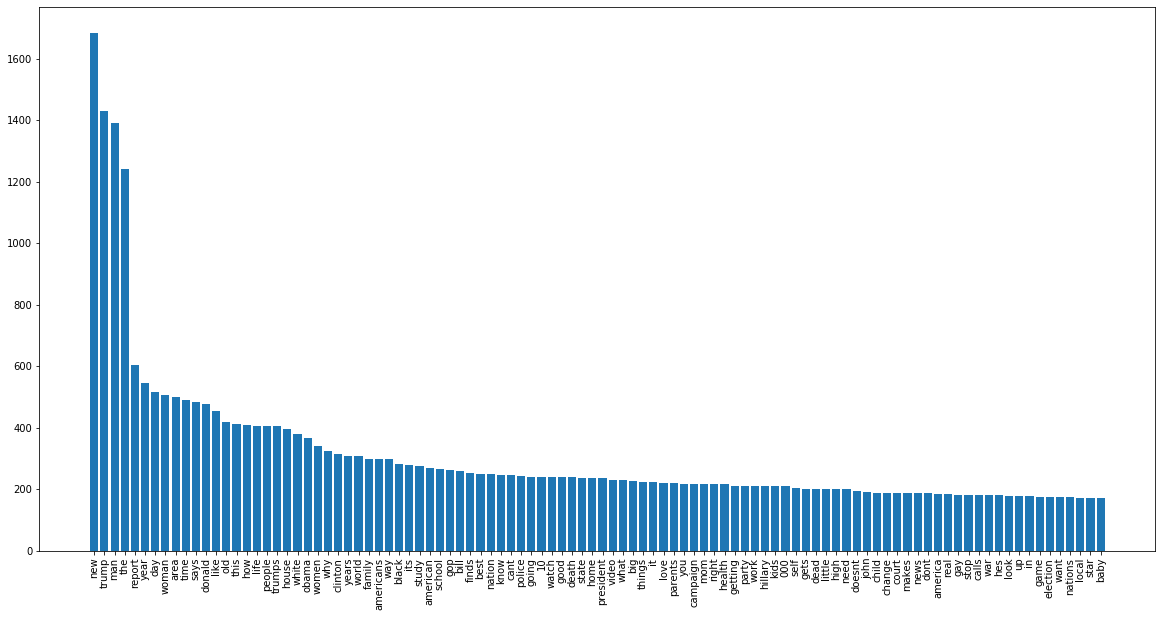

In [118]:
plot_histogram(dataset_vectorizer, features_dataset, n=100)

También lo graficamos para el set de entrenamiento generado:

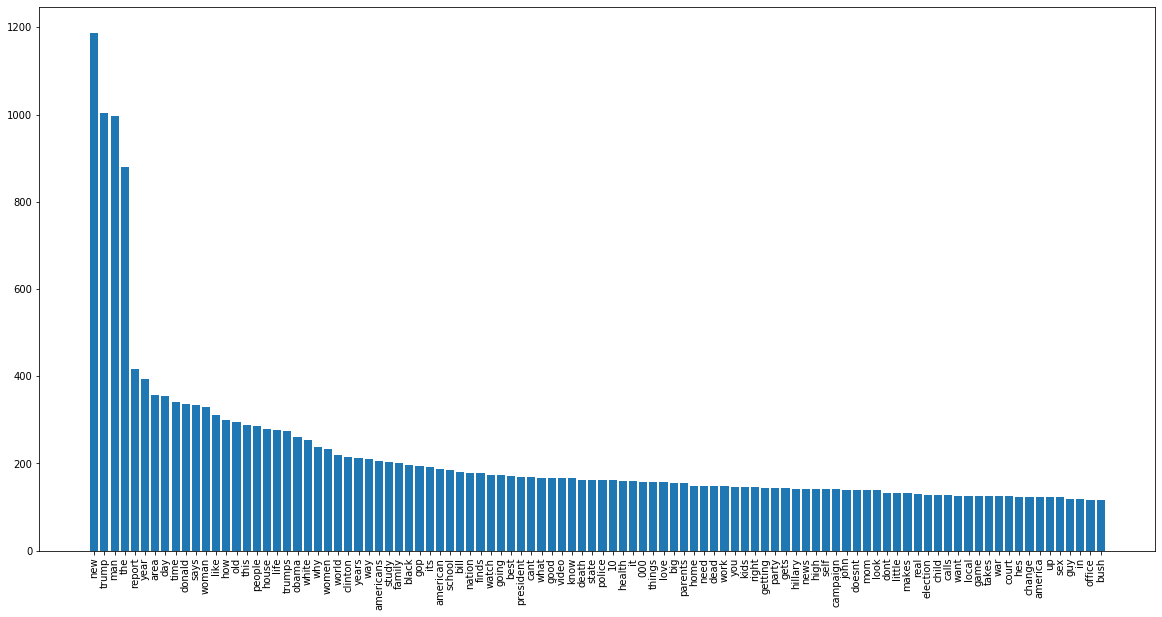

In [119]:
plot_histogram(vectorizer, features_train, n=100)

En ambos histogramas se puede observar que las 4 palabras más frecuentes en los dataset aparecen muchas más veces que el resto de palabras, formando una curva que inicialmente disminuye muy rápido pero luego se vuelve más uniforme. Esto implica que dichas palabras tendrán especial importancia al momento de entrenar el modelo, ya que aparecerán mucho más seguido que el resto. Es interesante también notar que la mayoría de palabras más frecuentes están relacionadas con temas político-sociales Estadounidenses, debido al origen de los dataset de estudio.

Comparando ambos gráficos, se ve que tienen una forma muy similar, pero en el caso del de entrenamiento, algunas palabras frecuentes se encuentran en distintos lugares respecto al dataset completo, esto debido a que se elige aleatoriamente el 70% de este para formar el set de entrenamiento, causando un 'desorden aleatorio' entre palabras que se repiten una cantidad similar de veces.

# Actividad 2

Para este estudio se eligió la codificación BoW (Bag of Words). Esta consiste en representar cada uno de los textos como un set de las palabras que estos contienen, considerando finalmente la multiplicidad de las palabras pero no el contexto en el que son utilizadas, ni tampoco el orden de éstas. Al utilizar esta codificación, las features utilizadas para entrenar serán las frecuencias de aparición de cada palabra, considerando todos los textos. Esta codificación tiene la ventaja de ser simple, pero la desventaja de no considerar el orden de las palabras ni el contexto, lo que puede generar un desempeño menor en comparación a técnicas como el word2vec, que utiliza redes neuronales pre-computadas para detectar el contexto en el que se basan los textos.

# Actividad 3

Se entrenan 6 modelos distintos de Support Vector Machines, variando el parámetro C (penalización del error) y el kernel utilizado:

In [120]:
from sklearn.svm import SVC

svm_a = SVC(C=1, kernel='rbf', gamma='scale') # Kernel de base radial
svm_a.fit(features_train, y_train)

svm_b = SVC(C=1, kernel='poly', gamma='scale') # Kernel polinomial
svm_b.fit(features_train, y_train)

svm_c = SVC(C=1, kernel='linear') # Kernel lineal, no requiere el parámetro 'gamma'
svm_c.fit(features_train, y_train)

svm_d = SVC(C=0.5, kernel='rbf', gamma='scale')
svm_d.fit(features_train, y_train)

svm_e = SVC(C=5, kernel='rbf', gamma='scale')
svm_e.fit(features_train, y_train)

svm_f = SVC(C=8, kernel='rbf', gamma='scale')
svm_f.fit(features_train, y_train)

SVC(C=8, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Ahora se aplican todos los modelos sobre el set de entrenamiento y de validación:

In [121]:
train_svm_a = svm_a.predict(features_train)
val_svm_a = svm_a.predict(features_val)

train_svm_b = svm_b.predict(features_train)
val_svm_b = svm_b.predict(features_val)

train_svm_c = svm_c.predict(features_train)
val_svm_c = svm_c.predict(features_val)

train_svm_d = svm_d.predict(features_train)
val_svm_d = svm_d.predict(features_val)

train_svm_e = svm_e.predict(features_train)
val_svm_e = svm_e.predict(features_val)

train_svm_f = svm_f.predict(features_train)
val_svm_f = svm_f.predict(features_val)

Como el dataset original estaba bien balanceado (cantidad similar de textos sarcásticos y NO sarcásticos), el Accuracy Score es una buena medida del rendimiento de los clasificadores. Por lo tanto se calcula para cada uno de los modelos:

In [122]:
from sklearn.metrics import accuracy_score

train_scores = []
for train_result in [train_svm_a, train_svm_b, train_svm_c, train_svm_d, train_svm_e, train_svm_f]:
    train_scores.append(accuracy_score(y_train, train_result))

validation_scores = []
for validation_result in [val_svm_a, val_svm_b, val_svm_c, val_svm_d, val_svm_e, val_svm_f]:
    validation_scores.append(accuracy_score(y_val, validation_result))

Finalmente se muestra toda la información en un DataFrame:

In [123]:
import pandas as pd

svm_data = {'C Value': [1, 1, 1, 0.5, 5, 8], 'Kernel': ['rbf', 'poly', 'linear', 'rbf', 'rbf', 'rbf'],
            'Training Set Accuracy': train_scores, 'Validation Set Accuracy': validation_scores}

svm_table = pd.DataFrame(svm_data)
svm_table

,C Value,Kernel,Training Set Accuracy,Validation Set Accuracy
0,1.0,rbf,0.980332,0.809457
1,1.0,poly,0.971297,0.661076
2,1.0,linear,0.982828,0.796180
3,0.5,rbf,0.935307,0.785232
4,5.0,rbf,0.999850,0.814349
5,8.0,rbf,0.999950,0.812485


Se puede observar que el kernel 'rbf' se ajusta mejor a los datos, y a medida que se aumenta el valor de C el rendimiento mejora. La excepción a la regla es el último modelo, que tiene el mayor valor de C (8), pero es ligeramente peor que el modelo que tiene C = 5 al aplicarlo sobre el set de validación. Esto ocurrió debido a que al penalizar tanto el error, el modelo se ajustó 'demasiado bien' a los datos del set de entrenamiento, generando Overfitting.

# Actividad 4

Analizamos nuevamente la tabla de resultados obtenida en la Actividad 3:

In [124]:
svm_table

,C Value,Kernel,Training Set Accuracy,Validation Set Accuracy
0,1.0,rbf,0.980332,0.809457
1,1.0,poly,0.971297,0.661076
2,1.0,linear,0.982828,0.796180
3,0.5,rbf,0.935307,0.785232
4,5.0,rbf,0.999850,0.814349
5,8.0,rbf,0.999950,0.812485


Para elegir el mejor modelo nos basaremos en el Accuracy Score, que es una buena métrica a utilizar en datasets balanceados. El modelo que mejor actuó sobre el set de validación fue el 5to (C=5, kernel='rbf'). Los modelos del 1 al 4 no se lograron ajustar tan bien a los datos (Underfitting), mientras que en el 6to ocurrió Overfitting al utilizar una penalización del error demasiado grande. 

In [125]:
best_svm = svm_e

A continuación aplicamos el mejor modelo de SVM sobre el set de testing:

In [126]:
test_best_svm = best_svm.predict(features_test)

Obtenemos el Accuracy Score para evaluar su rendimiento:

In [127]:
print(accuracy_score(y_test, test_best_svm))

0.8150477521546704


Finalmente, realizamos un pequeño análisis de algunos textos predichos correcta e incorrectamente:

In [128]:
correct_count = 10
incorrect_count = 10
correct_predictions = []
incorrect_predictions = []
for prediction, original, text in zip(test_best_svm, y_test, X_test):
    if correct_count and (prediction == original):
        correct_predictions.append((text, original))
        correct_count -= 1
    elif incorrect_count and (prediction != original):
        incorrect_predictions.append((text, original))
        incorrect_count -= 1

print('Correct Predictions\n')
for text in correct_predictions:
    print(f'Text: {text[0]}, isSarcastic: {bool(text[1])}')

print('\nIncorrect Predictions\n')
for text in incorrect_predictions:
    print(f'Text: {text[0]}, isSarcastic: {bool(text[1])}')

Correct Predictions

Text: elle magazine accidentally airbrushes naomi watts cover altogether, isSarcastic: True
Text: this its like free dive whales, isSarcastic: False
Text: the drag queen world series need know!, isSarcastic: False
Text: 13 year old boy diagnosed incurable puberty, isSarcastic: True
Text: israel vows use veto power chuck hagel confirmed u.s. secretary defense, isSarcastic: True
Text: first-grader given sticker behavior lockdown drill, isSarcastic: True
Text: donald trump didnt actually roll legal protections transgender kids, isSarcastic: False
Text: stylin pete king dress world crisis, isSarcastic: False
Text: un chief warns womens rights attack worldwide, isSarcastic: False
Text: perfect birthday card discovered local mall, isSarcastic: True

Incorrect Predictions

Text: woman enters miss universe malaysia finding beauty head-to-toe moles, isSarcastic: False
Text: dog waited spot month family return, isSarcastic: False
Text: anthropologists discover ancient greek 

Al revisar estos textos (sin Stop Words), es posible notar que en los que fueron incorrectamente predichos se ocupan en general palabras más específicas y apegadas al contexto, por lo que el clasificador no fue capaz de detectar correctamente si eran sarcásticos o no. También ocurre que en las predicciones incorrectas, los textos son menos 'intuitivos', en el sentido de que las palabras ocupadas en general pertenecen a mensajes de otra índole, dificultando la clasificación al no poder relacionarlas con el contexto del mensaje. Esto ocurre, por ejemplo, con el texto 'jon bon jovi jealous classmate jersey', donde rara vez se suelen usar esas palabras juntas en un mismo contexto.

# Actividad 5

Se entrenan 6 modelos distintos de MultiLayer Perceptron, variando la cantidad de capas y el tamaño de éstas:

In [129]:
from sklearn.neural_network import MLPClassifier

mlp_a = MLPClassifier(hidden_layer_sizes=(1), solver='adam', max_iter=30)
mlp_a.fit(features_train, y_train)

mlp_b = MLPClassifier(hidden_layer_sizes=(100, 100), solver='adam', max_iter=30)
mlp_b.fit(features_train, y_train)

mlp_c = MLPClassifier(hidden_layer_sizes=(10, 50, 100), solver='adam', max_iter=30)
mlp_c.fit(features_train, y_train)

mlp_d = MLPClassifier(hidden_layer_sizes=(100, 50, 10), solver='adam', max_iter=30)
mlp_d.fit(features_train, y_train)

mlp_e = MLPClassifier(hidden_layer_sizes=(150, 100, 50, 10, 1), solver='adam', max_iter=30)
mlp_e.fit(features_train, y_train)

mlp_f = MLPClassifier(hidden_layer_sizes=(1, 10, 50, 100, 150), solver='adam', max_iter=30)
mlp_f.fit(features_train, y_train)

C:\Users\Benja\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Benja\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Benja\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1, 10, 50, 100, 150),
              learning_rate='constant', learning_rate_init=0.001, max_iter=30,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Ahora se aplican todos los modelos sobre el set de validación:

In [130]:
val_mlp_a = mlp_a.predict(features_val)

val_mlp_b = mlp_b.predict(features_val)

val_mlp_c = mlp_c.predict(features_val)

val_mlp_d = mlp_d.predict(features_val)

val_mlp_e = mlp_e.predict(features_val)

val_mlp_f = mlp_f.predict(features_val)

Se grafica la pérdida con respecto al set de entrenamiento para cada uno de los modelos:

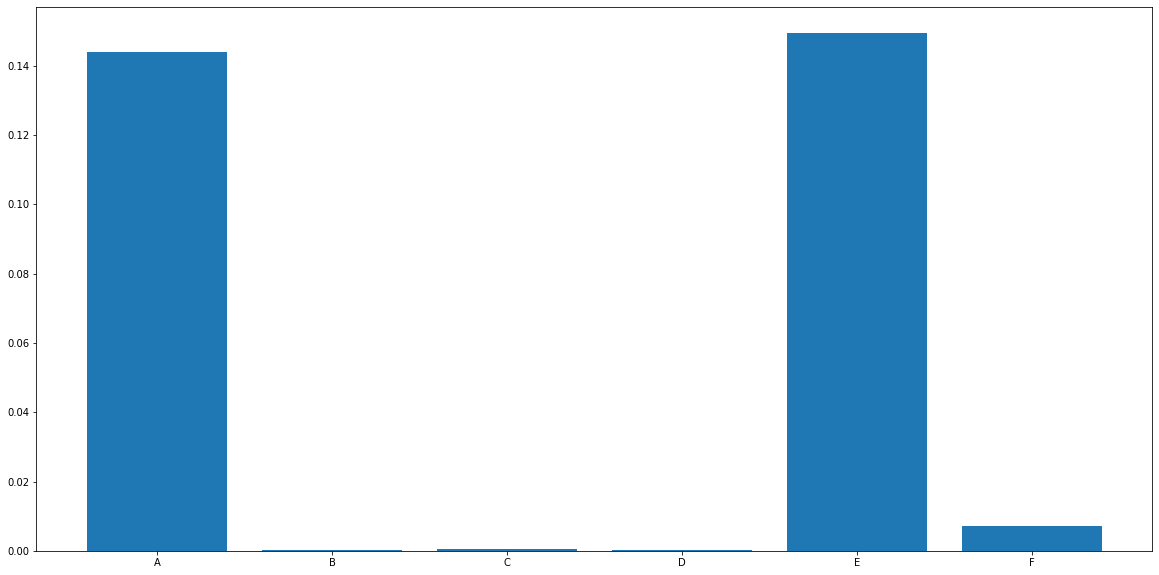

In [131]:
loss_values = []
for mlp in [mlp_a, mlp_b, mlp_c, mlp_d, mlp_e, mlp_f]:
    loss_values.append(mlp.loss_)

plt.figure(figsize=(20,10))
plt.bar(['A', 'B', 'C', 'D', 'E', 'F'], loss_values)
plt.show()

Se grafica la exactitud (Accuracy Score) en el set de validación para cada uno de los modelos:

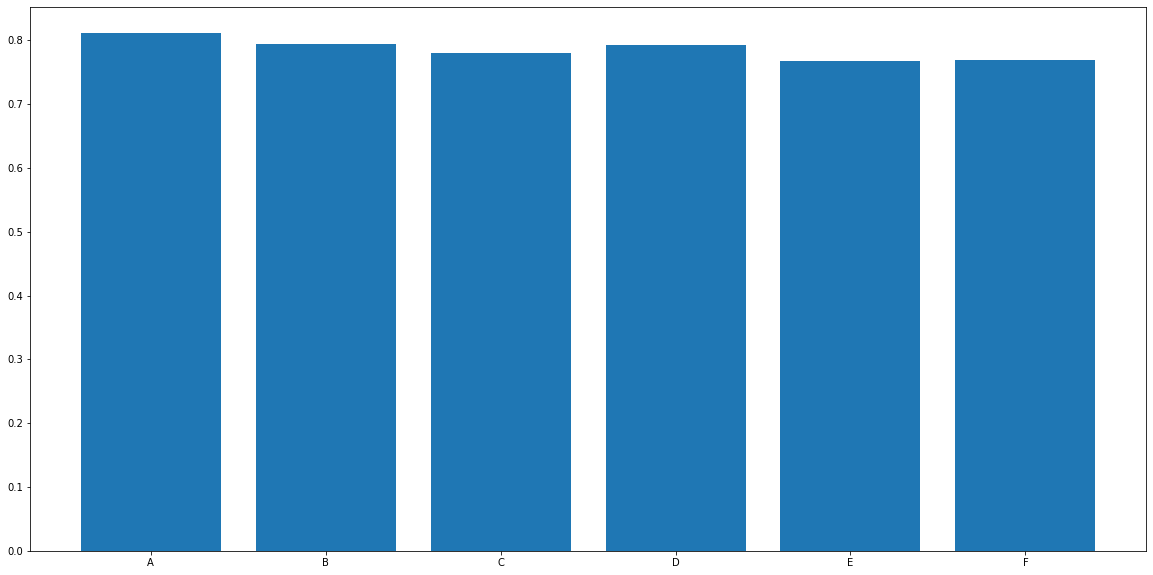

In [132]:
validation_scores_mlp = []
for validation_result_mlp in [val_mlp_a, val_mlp_b, val_mlp_c, val_mlp_d, val_mlp_e, val_mlp_f]:
    validation_scores_mlp.append(accuracy_score(y_val, validation_result_mlp))

plt.figure(figsize=(20,10))
plt.bar(['A', 'B', 'C', 'D', 'E', 'F'], validation_scores_mlp)
plt.show()

Al analizar ambos gráficos se puede inferir lo siguiente:

- En la mayoría de los modelos está ocurriendo Overfitting, puesto que el que mejor rendimiento tuvo en el set de validación fue el primero, que sólo posee 1 capa con 1 neurona. Esto también se puede evidenciar por los valores de pérdida en el set de entrenamiento, los que son muy bajos.

- Observando las pérdidas, los modelos B, C y D se ajustan mejor al set de entrenamiento, aunque esto genera Overfitting al aplicarlo en el de validación. Esto muestra que un número no muy grande de capas con una cantidad considerablemente grande de neuronas logran apegarse más a los datos.

- Al utilizar más capas o menos neuronas, los modelos no se ajustan tan bien a los datos, terminando con una mayor pérdida. Esto también ocurre (en algunos casos) debido a que no alcanzan a converger en las 30 épocas de entrenamiento.

# Actividad 6

Análogo a las SVM, analizamos la tabla de resultados para las distintas redes neuronales utilizadas:

In [133]:
mlp_data = {'Hidden Layers': [(1), (100, 100), (10, 50, 100), (100, 50, 10), (150, 100, 50, 10, 1), (1, 10, 50, 100, 150)],
            'Training Set Loss': loss_values, 'Validation Set Accuracy': validation_scores_mlp}

mlp_table = pd.DataFrame(mlp_data)
mlp_table

,Hidden Layers,Training Set Loss,Validation Set Accuracy
0,1,0.143831,0.811554
1,"(100, 100)",0.000301,0.794316
2,"(10, 50, 100)",0.000429,0.781039
3,"(100, 50, 10)",0.000295,0.793152
4,"(150, 100, 50, 10, 1)",0.149426,0.767063
5,"(1, 10, 50, 100, 150)",0.007164,0.769858


La red neuronal que mejor se ajusta corresponde a la 1ra:

In [134]:
best_mlp = mlp_a

A continuación aplicamos el mejor modelo de MLP sobre el set de testing:

In [135]:
test_best_mlp = best_mlp.predict(features_test)

Obtenemos el Accuracy Score para evaluar su rendimiento:

In [136]:
print(accuracy_score(y_test, test_best_mlp))

0.8094572559981364


Debido a que el primer modelo es más simple (sólo 1 capa oculta con 1 neurona), termina evitando caer en Overfitting al momento de entrenarse, finalmente resultando en el mejor clasificador para los datos. Los otros modelos se logran adaptar mejor al set de entrenamiento (la pérdida de algunos es mucho menor a la del primer modelo), pero debido a esto pierden generalidad y caen en Overfitting, resultando en peores clasificadores para los datos. También afecta el hecho de que al ser más complejos, en algunos casos no alcanzan a optimizarse y converger en las 30 iteraciones de entrenamiento, quedando 'incompletos'.

# Actividad 7

Realizamos un análisis sobre algunos textos predichos correcta e incorrectamente:

In [137]:
correct_count = 10
incorrect_count = 10
correct_predictions = []
incorrect_predictions = []
for prediction, original, text in zip(test_best_mlp, y_test, X_test):
    if correct_count and (prediction == original):
        correct_predictions.append((text, original))
        correct_count -= 1
    elif incorrect_count and (prediction != original):
        incorrect_predictions.append((text, original))
        incorrect_count -= 1

print('Correct Predictions\n')
for text in correct_predictions:
    print(f'Text: {text[0]}, isSarcastic: {bool(text[1])}')

print('\nIncorrect Predictions\n')
for text in incorrect_predictions:
    print(f'Text: {text[0]}, isSarcastic: {bool(text[1])}')

Correct Predictions

Text: elle magazine accidentally airbrushes naomi watts cover altogether, isSarcastic: True
Text: this its like free dive whales, isSarcastic: False
Text: the drag queen world series need know!, isSarcastic: False
Text: israel vows use veto power chuck hagel confirmed u.s. secretary defense, isSarcastic: True
Text: first-grader given sticker behavior lockdown drill, isSarcastic: True
Text: donald trump didnt actually roll legal protections transgender kids, isSarcastic: False
Text: stylin pete king dress world crisis, isSarcastic: False
Text: un chief warns womens rights attack worldwide, isSarcastic: False
Text: perfect birthday card discovered local mall, isSarcastic: True
Text: republican sen. gardner torches sessions pot reversal, isSarcastic: False

Incorrect Predictions

Text: 13 year old boy diagnosed incurable puberty, isSarcastic: True
Text: woman enters miss universe malaysia finding beauty head-to-toe moles, isSarcastic: False
Text: dog waited spot month

La MLP logra 'deducir' mejor el contexto de los mensajes, siendo capaz de predecir correctamente algunos textos que la SVM no fue capaz. Esto implica que las MLP se terminan apegando más a los datos que las SVM, lo que también lleva a problemas, como el no rendir bien cuando las palabras utilizadas en un texto son poco comunes en el set de entrenamiento. Esto ocurre, por ejemplo, en el texto 'anthropologists discover ancient greek super pac helped shape democracy', que probablemente no tiene ningún parecido a algún texto del set de entrenamiento.

Como conclusión, se podría decir que las SVM rinden mejor en casos en los que las palabras ocupadas suelen estar más relacionadas entre sí, sin depender mucho del contexto, mientras que las MLP rinden mejor cuando se ocupan textos similares a los del set de entrenamiento, y se apegan más al contexto.